<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/CUDA_Accelerated_Rotating_Wave_Approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# @title 0) Setup: CuPy (GPU) or NumPy (CPU) + pylint
import importlib, sys, subprocess

def _ensure(pkg: str) -> None:
    try:
        __import__(pkg.split("==")[0])
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Prefer CuPy if present; try to install a CUDA 12.x build in Colab if needed.
try:
    import cupy as cp  # noqa: F401
    backend = "cupy"
except Exception:
    try:
        _ensure("cupy-cuda12x")
        import cupy as cp  # noqa: F401
        backend = "cupy"
    except Exception:
        _ensure("numpy>=1.26")
        backend = "numpy"

_ensure("pylint>=3.2.0")
print("Array backend:", backend)


Array backend: cupy


In [6]:
# @title 1) Write `rwa_gpu.py` (analytical RWA + effective + numeric Rabi)
from pathlib import Path
code = r'''
# -*- coding: utf-8 -*-
"""RWA utilities with optional GPU acceleration (CuPy→NumPy fallback).

API
---
backend() -> (xp, is_gpu)
asnumpy(a) -> np.ndarray

paulis(xp=None) -> (sx, sy, sz, I)
ladder(xp=None) -> (sp, sm)

rwa_hamiltonian(Delta, Omega, xp=None) -> 2x2
rwa_unitary(Delta, Omega, t, xp=None) -> (..., 2, 2)
rwa_prob_e(Delta, Omega, t, init="g", xp=None) -> (N,)

bloch_siegert_shift(omega0, Omega, omega=None, mode="general") -> float
    mode: "general" uses Ω²/[4(ω0+ω)] if ω is given; "near_resonant" uses Ω²/(4ω0).

rabi_evolution_numeric(omega0, Omega, omega_d, tgrid, init="g",
                       bloch_siegert=False, bs_mode="general", xp=None)
    -> (times(N,), states(N,2,1), Pe(N,))
"""
from __future__ import annotations
from typing import Tuple
import importlib
import math

def backend():
    """Return (xp, is_gpu): xp is cupy if available, else numpy."""
    try:
        xp = importlib.import_module("cupy")
        return xp, True
    except Exception:
        xp = importlib.import_module("numpy")
        return xp, False

def asnumpy(a):
    """Return a NumPy array whether `a` is CuPy or NumPy."""
    xp, _ = backend()
    if hasattr(xp, "asnumpy"):
        return xp.asnumpy(a)
    import numpy as _np
    return _np.asarray(a)

def paulis(xp=None):
    xp = xp or backend()[0]
    c = xp.array
    sx = c([[0.0, 1.0],[1.0, 0.0]], dtype=xp.complex128)
    sy = c([[0.0, -1.0j],[1.0j, 0.0]], dtype=xp.complex128)
    sz = c([[1.0, 0.0],[0.0, -1.0]], dtype=xp.complex128)
    I  = c([[1.0, 0.0],[0.0,  1.0]], dtype=xp.complex128)
    return sx, sy, sz, I

def ladder(xp=None):
    xp = xp or backend()[0]
    sp = xp.array([[0.0, 1.0],[0.0, 0.0]], dtype=xp.complex128)  # |e><g|
    sm = xp.array([[0.0, 0.0],[1.0, 0.0]], dtype=xp.complex128)  # |g><e|
    return sp, sm

def rwa_hamiltonian(Delta: float, Omega: float, xp=None):
    """H_RWA/ħ = (Δ/2)σz + (Ω/2)σx."""
    xp = xp or backend()[0]
    sx, _, sz, _ = paulis(xp)
    return 0.5*Delta*sz + 0.5*Omega*sx

def rwa_unitary(Delta: float, Omega: float, t, xp=None):
    """Analytical U_RWA(t) for H_RWA/ħ = (Δ/2)σz + (Ω/2)σx."""
    xp = xp or backend()[0]
    sx, _, sz, I = paulis(xp)
    Delta = xp.asarray(Delta, dtype=xp.float64)
    Omega = xp.asarray(Omega, dtype=xp.float64)
    t     = xp.asarray(t,     dtype=xp.float64)
    Omega_R = xp.sqrt(Delta*Delta + Omega*Omega)
    nz = Delta / (Omega_R + 1e-16)
    nx = Omega / (Omega_R + 1e-16)
    Hhat = 0.5*(nz*sz + nx*sx)  # normalized by Ω_R
    phase = 0.5*Omega_R*t
    ct, st = xp.cos(phase), xp.sin(phase)
    return ct[..., None, None]*I - 1.0j*st[..., None, None]*(2.0*Hhat)

def rwa_prob_e(Delta: float, Omega: float, t, init: str = "g", xp=None):
    """Excited-state probability under RWA from |g⟩ or |e⟩. Returns (N,)."""
    xp = xp or backend()[0]
    ket_g = xp.array([[0.0],[1.0]], dtype=xp.complex128)  # |g⟩
    ket_e = xp.array([[1.0],[0.0]], dtype=xp.complex128)  # |e⟩
    psi0  = ket_g if init.lower().startswith("g") else ket_e
    U = rwa_unitary(Delta, Omega, t, xp=xp)      # (..., 2, 2)
    psi_t = U @ psi0                             # (..., 2, 1)
    amp_e = xp.conjugate(ket_e).T @ psi_t        # (..., 1, 1)
    pe = xp.real(amp_e * xp.conjugate(amp_e))    # (..., 1, 1)
    return pe.reshape(-1)

def bloch_siegert_shift(omega0: float, Omega: float, omega: float|None=None, mode: str="general"):
    """Leading Bloch–Siegert frequency correction δ_BS.
    general:  δ ≈ Ω²/[4(ω0+ω)]  (use given ω)
    near_resonant: δ ≈ Ω²/(4ω0) (ω≈ω0)
    """
    if mode == "near_resonant" or omega is None:
        return (Omega*Omega) / (4.0*omega0 + 1e-16)
    return (Omega*Omega) / (4.0*(omega0 + omega) + 1e-16)

def _expm2x2(xp, H, dt):
    """2x2 matrix exponential via Hermitian eigendecomposition."""
    w, V = xp.linalg.eigh(H)
    return V @ xp.diag(xp.exp(-1.0j*w*dt)) @ xp.conjugate(V).T

def rabi_evolution_numeric(omega0: float, Omega: float, omega_d: float, tgrid,
                           init: str="g", bloch_siegert: bool=False, bs_mode: str="general", xp=None):
    """Time-ordered evolution under H/ħ = (ω0/2)σz + Ω cos(ω_d t) σx.
    If bloch_siegert=True: use ω0 → ω0 + δ_BS leading correction.
    Returns (t(N,), states(N,2,1), Pe(N,)).
    """
    xp = xp or backend()[0]
    sx, _, sz, _ = paulis(xp)
    ket_g = xp.array([[0.0],[1.0]], dtype=xp.complex128)
    ket_e = xp.array([[1.0],[0.0]], dtype=xp.complex128)
    psi  = ket_g if init.lower().startswith("g") else ket_e

    omega0 = float(omega0)
    Omega  = float(Omega)
    omega_d= float(omega_d)
    if bloch_siegert:
        omega0 = omega0 + bloch_siegert_shift(omega0, Omega, omega_d, mode=bs_mode)

    t = xp.asarray(tgrid, dtype=xp.float64).ravel()
    dt = xp.diff(t)
    states = xp.empty((t.size, 2, 1), dtype=xp.complex128)
    states[0,:,:] = psi

    for k, dtk in enumerate(dt, start=1):
        tk = float(0.5*(t[k-1] + t[k]))
        H = 0.5*omega0*sz + Omega*math.cos(omega_d*tk)*sx
        U = _expm2x2(xp, H, dtk)
        psi = U @ psi
        states[k,:,:] = psi

    amp_e = xp.conjugate(ket_e).T @ states
    Pe = xp.real(amp_e * xp.conjugate(amp_e)).reshape(-1)
    return t, states, Pe
'''
Path("rwa_gpu.py").write_text(code, encoding="utf-8")
print("Wrote:", Path("rwa_gpu.py").resolve())


Wrote: /content/rwa_gpu.py


In [8]:
# @title 2) Demo: compare RWA (analytic) to full Rabi (numeric) — compatibility-safe
import importlib, inspect
import rwa_gpu as _rg

# Ensure the module on disk is the one in memory (important in notebooks)
importlib.reload(_rg)  # picks up any edits to rwa_gpu.py

# Backend & handles
xp, is_gpu = _rg.backend()
rwa_prob_e = _rg.rwa_prob_e

# Wrapper: only pass 'bs_mode' if the function actually accepts it
def _call_rabi(omega0, Omega, omega_d, tgrid, *, init="g", bloch_siegert=False, bs_mode="general", xp=None):
    sig = inspect.signature(_rg.rabi_evolution_numeric)
    if "bs_mode" in sig.parameters:
        return _rg.rabi_evolution_numeric(
            omega0, Omega, omega_d, tgrid,
            init=init, bloch_siegert=bloch_siegert, bs_mode=bs_mode, xp=xp
        )
    # Older signature: no 'bs_mode'
    return _rg.rabi_evolution_numeric(
        omega0, Omega, omega_d, tgrid,
        init=init, bloch_siegert=bloch_siegert, xp=xp
    )

# ---- Parameters (ħ = 1; angular frequencies in rad/s) ----
omega0 = 2.0 * xp.pi * 5.0e6        # 5 MHz transition
Omega  = 2.0 * xp.pi * 0.8e6        # Rabi rate
omega_d = omega0 - 2.0 * xp.pi * 0.2e6  # drive = 0.2 MHz below resonance
Delta = float(omega0 - omega_d)

t_end = 60e-6
N = 2000
t = xp.linspace(0.0, t_end, N)

# ---- RWA (analytic) ----
Pe_rwa = rwa_prob_e(Delta, Omega, t, init="g", xp=xp)

# ---- Full Rabi (numeric), with and without Bloch–Siegert ----
t_num, _, Pe_full = _call_rabi(omega0, Omega, omega_d, t, init="g", bloch_siegert=False, xp=xp)
_,     _, Pe_bs   = _call_rabi(omega0, Omega, omega_d, t, init="g", bloch_siegert=True,  bs_mode="general", xp=xp)

print("Backend:", "GPU (CuPy)" if is_gpu else "CPU (NumPy)")
print("Shapes:", Pe_rwa.shape, Pe_full.shape, Pe_bs.shape)


Backend: GPU (CuPy)
Shapes: (2000,) (2000,) (2000,)


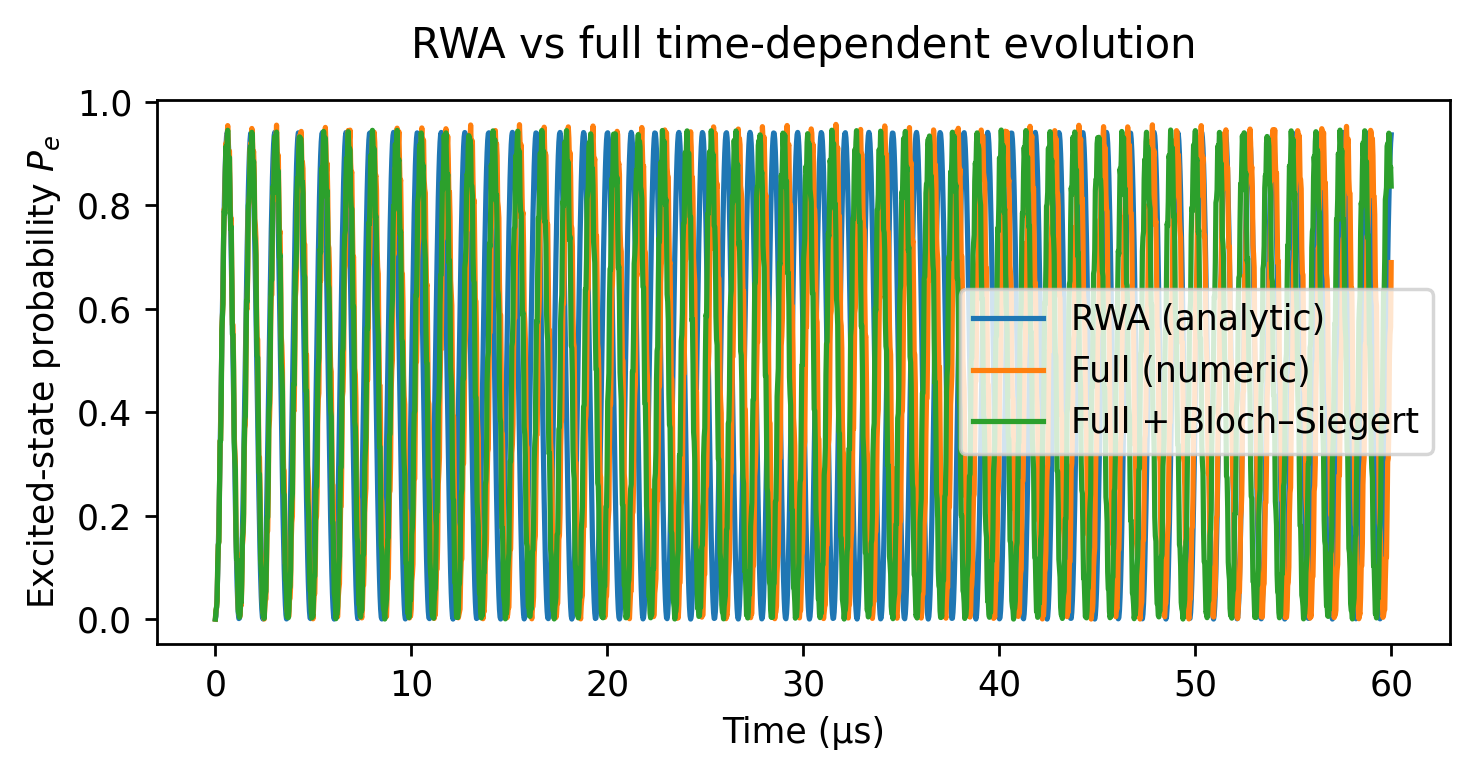

In [10]:
# @title 2b) Plot the three traces (RWA, full, full+BS) — backend safe
import numpy as np
import matplotlib.pyplot as plt
from rwa_gpu import asnumpy  # uses CuPy.asnumpy if available

plt.rcParams['figure.dpi'] = 250

t_np      = asnumpy(t).reshape(-1)
Pe_rwa_np = asnumpy(Pe_rwa).reshape(-1)
t_num_np  = asnumpy(t_num).reshape(-1)
Pe_full_np= asnumpy(Pe_full).reshape(-1)
Pe_bs_np  = asnumpy(Pe_bs).reshape(-1)

plt.figure(figsize=(6.0, 3.2))
plt.plot(t_np*1e6, Pe_rwa_np,  label="RWA (analytic)")
plt.plot(t_num_np*1e6, Pe_full_np, label="Full (numeric)")
plt.plot(t_num_np*1e6, Pe_bs_np,   label="Full + Bloch–Siegert")
plt.xlabel("Time (µs)")
plt.ylabel("Excited-state probability $P_e$")
plt.title("RWA vs full time-dependent evolution", pad=12)
plt.legend()
plt.tight_layout()
plt.show()
